# Comparing gdist geodesic distance solver to pycortex's heat method

Testing the accuracy of pycortex's approximate, heat-based method for computing geodesic distances (see [Crane et al., "Geodesics in Heat" 2012](http://arxiv.org/pdf/1204.6216)) relative to [gdist's exact method](https://github.com/the-virtual-brain/tvb-geodesic). Also comparing the performance of the two algorithms.

#### Summary:

pycortex's method gives very similar answers to the exact method, although pycortex's estimates are too big by ~10mm for the longest distances.

Performance-wise, pycortex's method is ~20x faster (on i7 5930K) for finding 1-to-all or many-to-all distances. Limiting the maximum distance (i.e. setting all distances greater than some value to _inf_) improves the performance of gdist substantially (pycortex's algorithm necessarily computes distances to all points) but is still slower than pycortex's method.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from matplotlib.pyplot import *

In [4]:
import cortex
from cortex.polyutils import Surface
import gdist

In [6]:
# Load surfaces
lpts, lpolys = cortex.db.get_surf('AHfs', 'fiducial', 'lh')
lsurf = Surface(lpts, lpolys)

In [100]:
v0 = np.array([18360], dtype=np.int32) # start vertex, chosen at random
v_all = np.arange(len(lsurf.pts), dtype=np.int32)
v_few = np.arange(100, dtype=np.int32) # start vertices
v_some = np.arange(10000, dtype=np.int32) # end vertices

## Compare computed distances

In [75]:
gd_dists_all = gdist.compute_gdist(lsurf.pts, lsurf.polys.astype(np.int32), v0, v_all)

In [92]:
cx_dists_all = lsurf.geodesic_distance(v0)

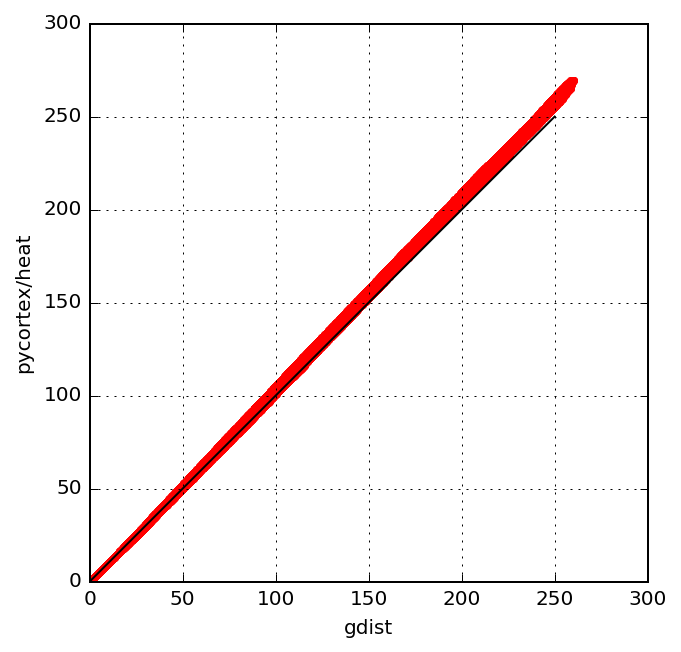

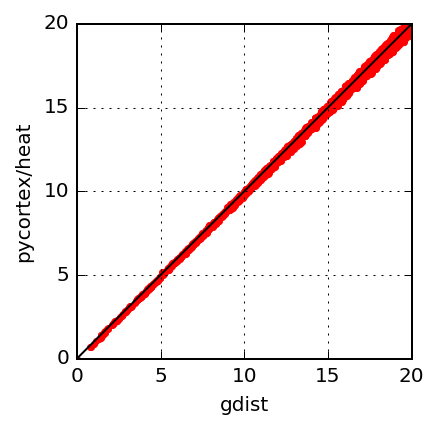

In [93]:
figure(figsize=(5,5))
plot(gd_dists_all, cx_dists_all, 'r.')
plot([0, 250], [0, 250], 'k-')
grid()
xlabel('gdist'); ylabel('pycortex/heat');

figure(figsize=(3,3))
plot(gd_dists_all, cx_dists_all, 'r.')
plot([0, 200], [0, 200], 'k-')
xlim(0, 20); ylim(0, 20); grid()
xlabel('gdist'); ylabel('pycortex/heat');

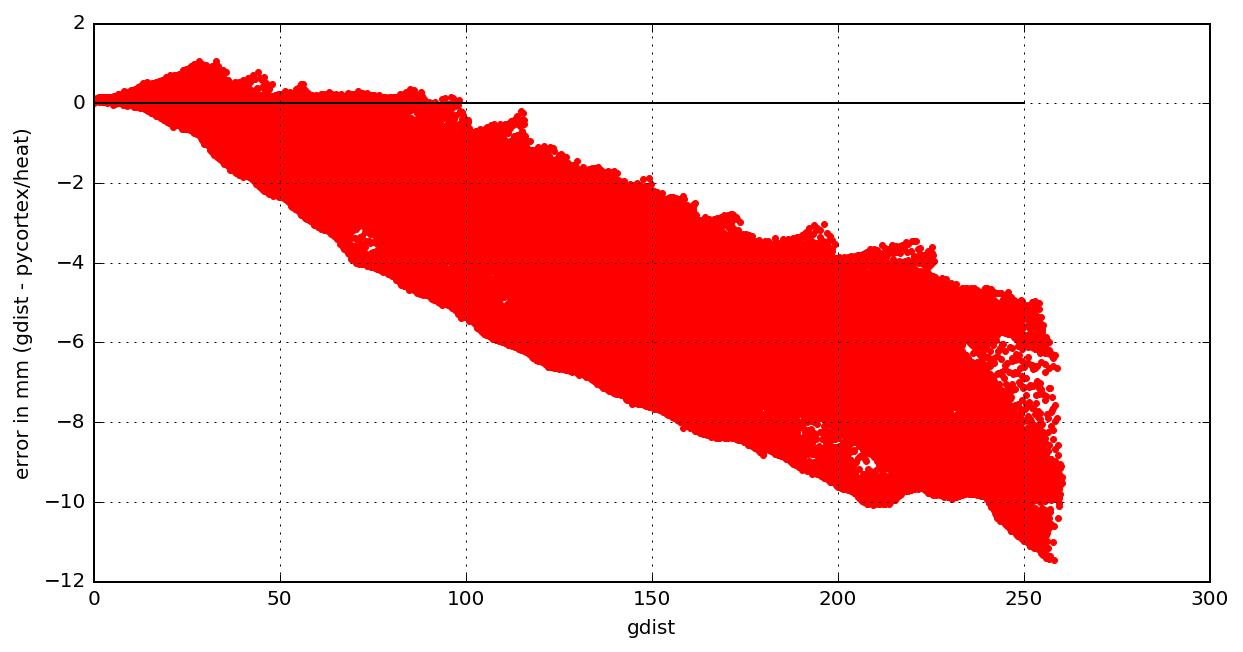

In [94]:
figure(figsize=(10,5))
plot(gd_dists_all, gd_dists_all - cx_dists_all, 'r.')
plot([0, 250], [0, 0], 'k-'); grid()
xlabel('gdist'); ylabel('error in mm (gdist - pycortex/heat)');

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


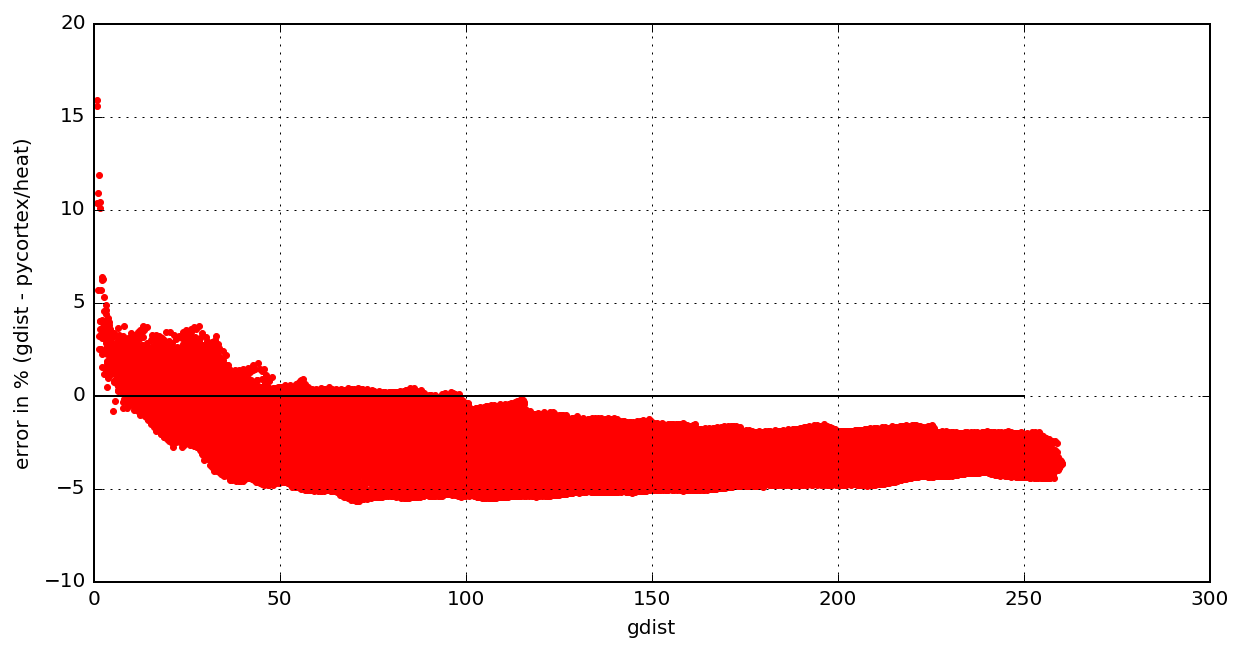

In [95]:
figure(figsize=(10,5))
plot(gd_dists_all, (gd_dists_all - cx_dists_all) / gd_dists_all * 100, 'r.')
plot([0, 250], [0, 0], 'k-'); grid()
xlabel('gdist'); ylabel('error in % (gdist - pycortex/heat)');

In [96]:
print "correlation:", np.corrcoef(gd_dists_all, cx_dists_all)[0,1]

correlation: 0.999833224361


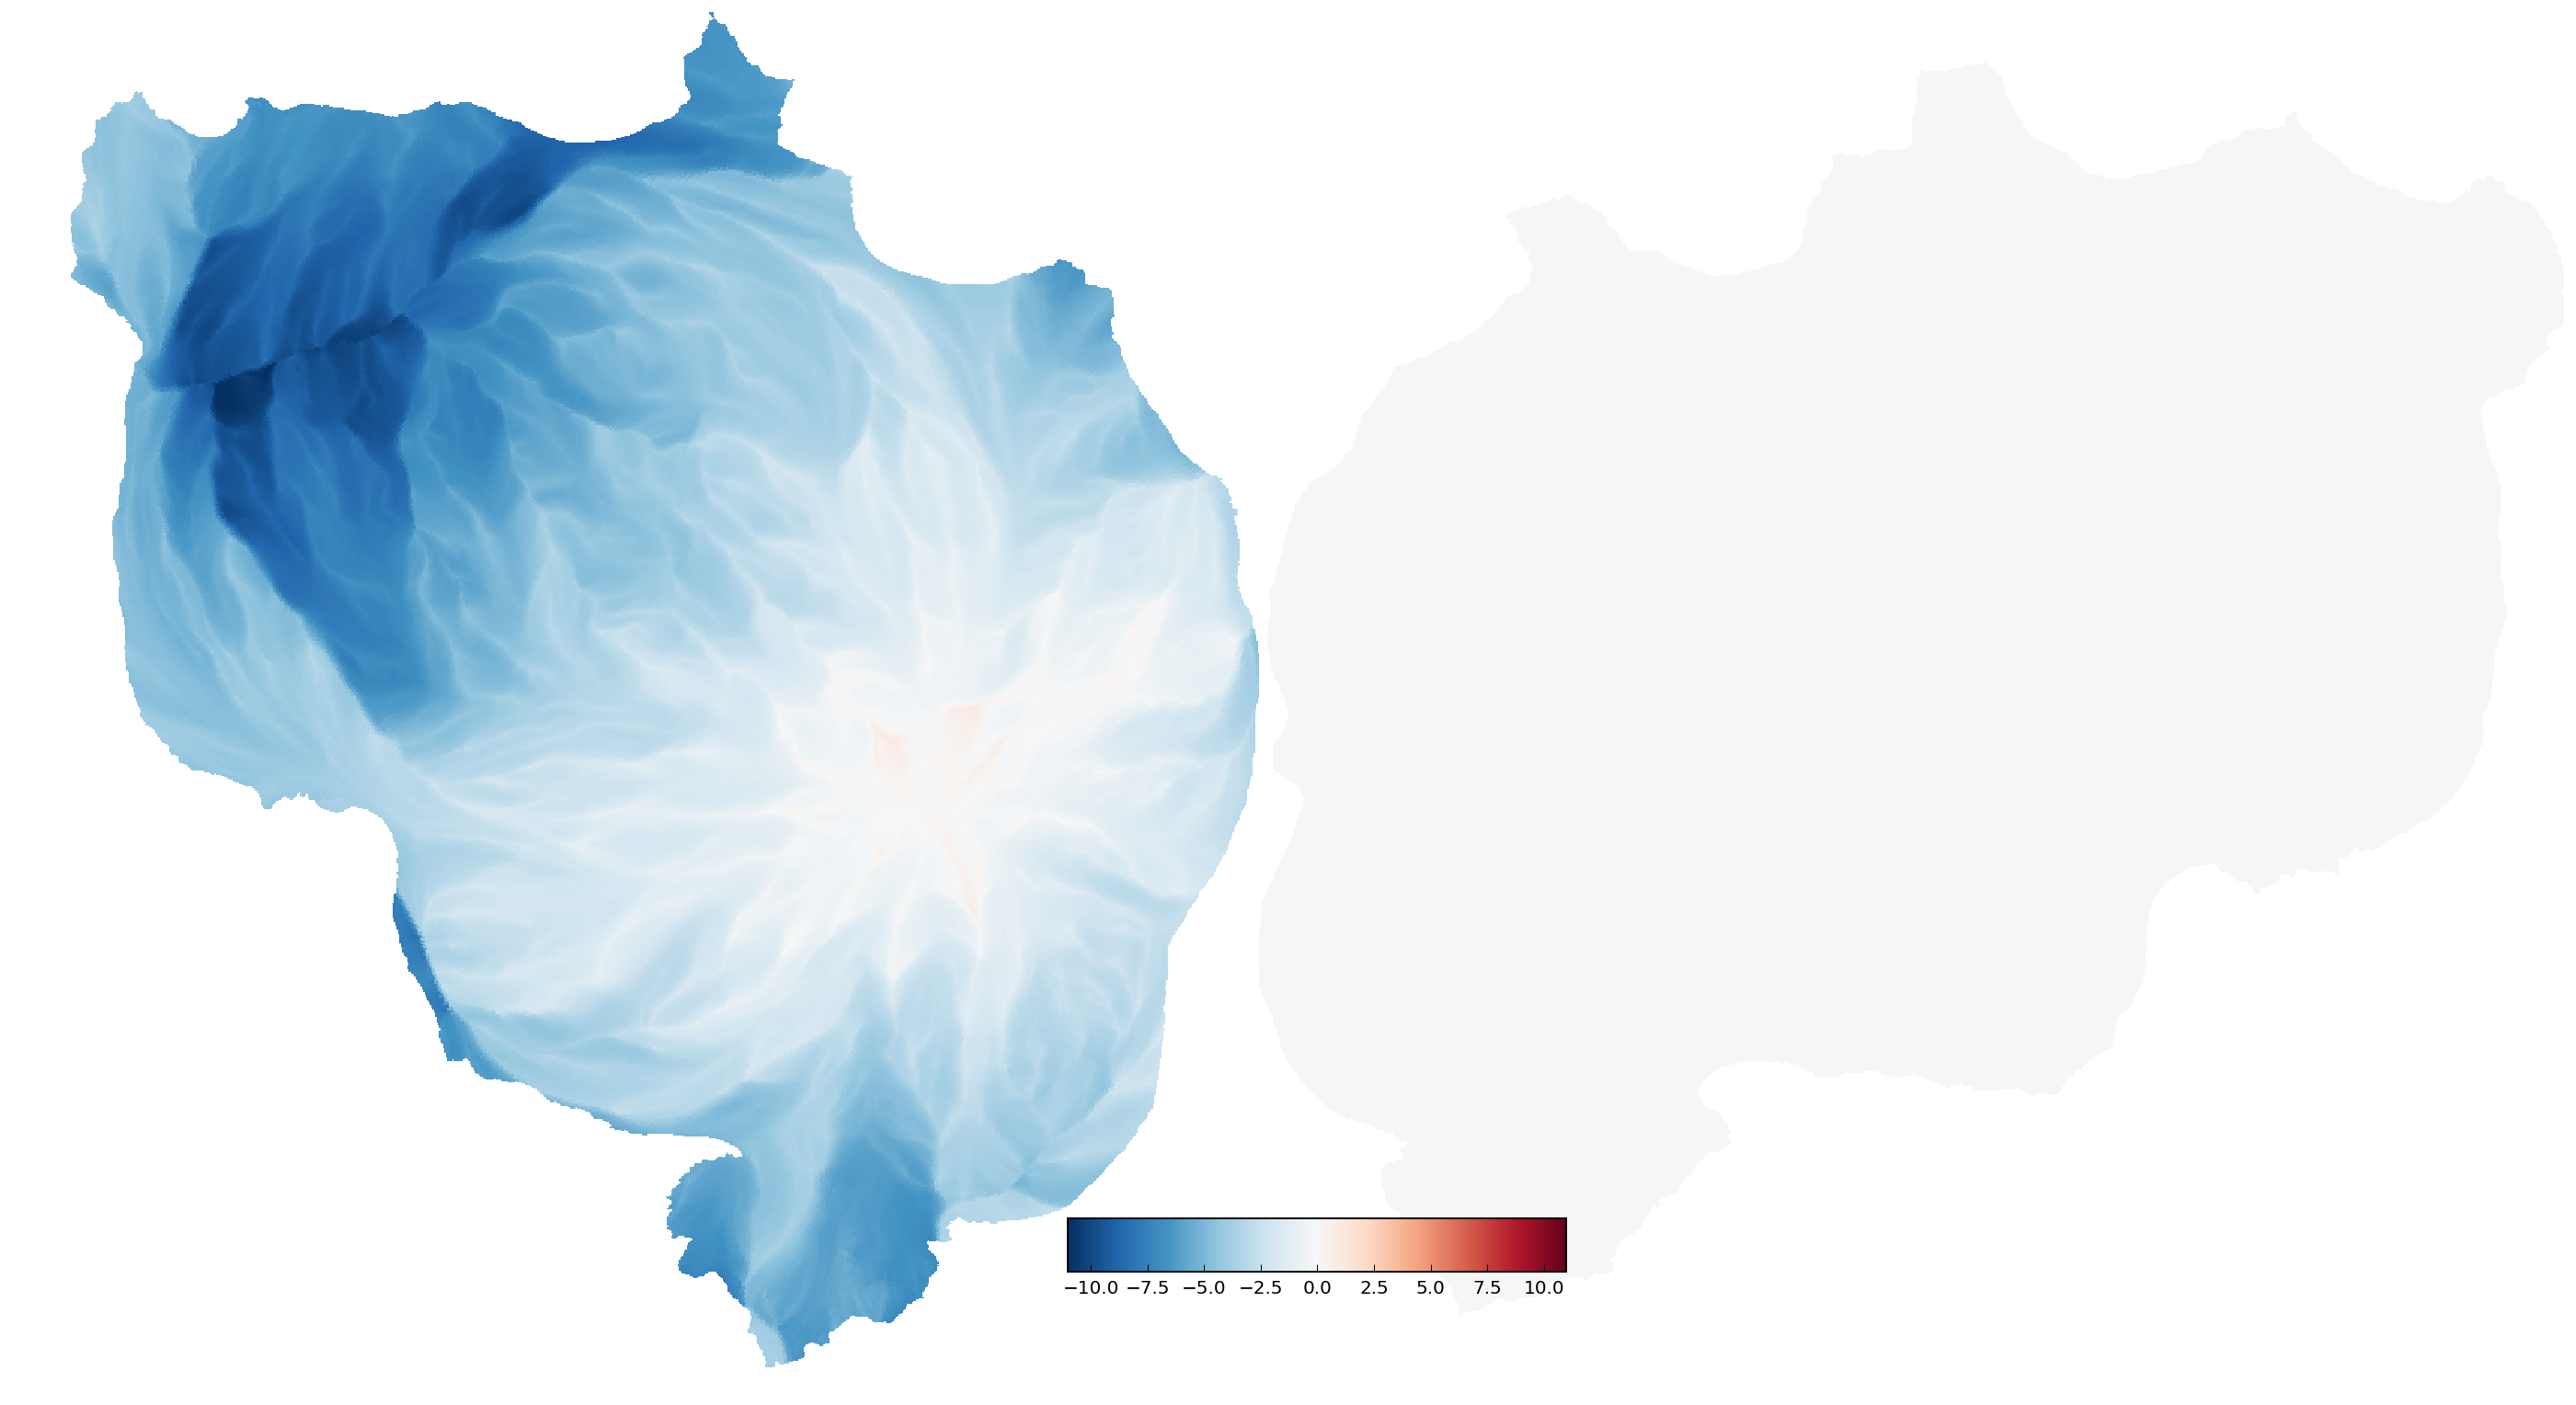

In [97]:
cortex.quickshow(cortex.Vertex(gd_dists_all - cx_dists_all, 'AHfs', cmap=cm.RdBu_r, vmin=-11, vmax=11),
                with_labels=False, with_rois=False);

## Compare timing

(all after pycortex has warmed up its geodesic solver)

### 1-to-all

In [29]:
%timeit gdist.compute_gdist(lsurf.pts, lsurf.polys.astype(np.int32), v0, v_all, 999.)

1 loop, best of 3: 3.76 s per loop


In [30]:
%timeit lsurf.geodesic_distance(v0)

1 loop, best of 3: 169 ms per loop


In [31]:
print "ratio:", 3.76 / 0.169

ratio: 22.2485207101


### 1-to-some (10k verts)

In [34]:
%timeit gdist.compute_gdist(lsurf.pts, lsurf.polys.astype(np.int32), v0, v_some)

1 loop, best of 3: 3.56 s per loop


In [33]:
%timeit lsurf.geodesic_distance(v0)[v_some]

10 loops, best of 3: 170 ms per loop


In [35]:
print "ratio:", 3.56 / 0.170

ratio: 20.9411764706


### 1-to-nearby (15mm)

In [39]:
%timeit gdist.compute_gdist(lsurf.pts, lsurf.polys.astype(np.int32), v0, max_distance=15.)

1 loop, best of 3: 333 ms per loop


In [40]:
%timeit lsurf.geodesic_distance(v0) # assuming we have to set some to np.inf later, fine..

10 loops, best of 3: 170 ms per loop


In [41]:
print "ratio:", 0.333 / 0.170

ratio: 1.95882352941


### few-to-all

In [101]:
%timeit gdist.compute_gdist(lsurf.pts, lsurf.polys.astype(np.int32), v_few, v_all)

1 loop, best of 3: 3.55 s per loop


In [108]:
%timeit lsurf.geodesic_distance(v_few)

1 loop, best of 3: 182 ms per loop


In [109]:
print "ratio:", 3.55 / 0.182

ratio: 19.5054945055


Neither method has a big cost to computing distances from multiple start points. Nice!